<a href="https://colab.research.google.com/github/Victorlouisdg/differentiable-cloth-folding/blob/master/springs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring Simulator
This notebook shows how to create a simple spring simulator based on Hooke's law. 

In [0]:
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')

## Point Masses
The basic building blocks of the simulation are the point masses.
Each point mass will have a state consisting of its position and velocity.
They have mass, but do not take up space. 

<img src="https://drive.google.com/uc?export=view&id=1aoKmtBkfrQNWY6wRN51e-StdIUXKyzKg" alt="point_mass_2D" width="300"/>


We will store the state of the system in a 2D-array. Each row holds the state of a single points mass. The first columns will hold the positions of the masses, the last columns de velocities.

In this notebook we restrict ourselves to a 2D simulation. The state array will thus have 4 columns.

### Defining the initial state

In [2]:
pa = np.zeros(2)
pb = np.array([1.0, 0.0])
va = np.zeros(2)
vb = np.zeros(2)

p = np.vstack([pa, pb])
v = np.vstack([va, vb])
s0 = np.hstack([p, v])

print(' x, y, vx, vy')
print(s0)

 x, y, vx, vy
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]]


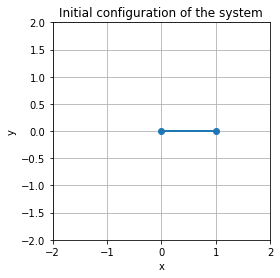

In [3]:
x, y = np.transpose(p)  # Reads the x and y columns

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', xlim=(-2, 2), ylim=(-2, 2))
ax.grid()
ax.set_title('Initial configuration of the system')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y, 'o-', lw=2);

## Hooke's law
To simulate the springs we use Hooke's law. 

Hooke's law states that the force exerted by a spring scales linearly with how much its elongated/compressed:

$\overrightarrow{F} = -k . \overrightarrow{x}$

where:


*   $k$ is a constant, the spring stiffness
*   $\overrightarrow{x}$ is the relative elongation along the spring: $(l - l_{rest}) \overrightarrow{u}$
*   $\overrightarrow{u}$  a unit vector along the spring (= the normalized version of $\overrightarrow{d}$)
*   $\overrightarrow{d}$ is the vector between the two endpoints of the springs
*   $l$ is the current length of the spring (= $ \lVert \overrightarrow{d} 
\rVert$)
* $l_{rest}$ is the length of the spring at rest

(Sidenote: in the function below we can drop the minus sign because of the order of substraction to calculate $\overrightarrow{d}$)

In [0]:
def hooke(pa, pb, k, l_rest):
    d = pa - pb  # d points from b to a 
    l = np.linalg.norm(d)
    u = d / l
    x = (l - l_rest) * u
    F = k * x
    return F  # force on a 

## Simulation
To simulate a system we need two things:


1.   A description of how the system changes in time
2.   A way to advance the simulation in time

---


### 1. Change of the system state in time
Hooke's law tells us, given the positions of the masses in the system, how much force the springs exert on them. 
Newton's second law $F = m.a$ allows us to find the acceleration they undergo. Further, we know that acceleration is the rate of change of velocity; and velocity is the rate of change of position. 

The `change_of(s)` function in the cell below calculates the current rate of change of the state, given the state. 

---

### 2. Advancing time
The simplest way to advance time is just to iteratively evaluate the current rate of change and take small steps forward like so:



```
s_new = s + change_of(s) * dt
```

However, for computational reasons we use [Runge Kutta 4](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4) to advance time.
It looks slightly more complex, but the principle is the same!

In [0]:
# Physical constants
m = 0.1        # kg
k = 5.0        # N / m
l_rest = 1.0   # m
g = 9.80665    # m/s^2
ag = np.array([0.0, -g])  # acceleration due to gravity


def change_of(s):
    p, v = np.hsplit(s, 2)
    pa, pb = np.vsplit(p, 2)
    va, vb = np.vsplit(v, 2)

    F = hooke(pa, pb, k, l_rest)
    a = F / m
    a += ag

    # Change of position = velocity, change of velocity = acceleration
    change_of_sa = np.zeros(4) # The state of mass 'a' never changes
    change_of_sb = np.hstack([vb, a]) 
    return np.vstack([change_of_sa, change_of_sb])


steps = 500
dt = 0.01  # s 

def simulate(s0, steps, dt):
    history = [s0]
    s = s0
    for t in range(steps):
        # RK4 step
        k1 = change_of(s)
        k2 = change_of(s + k1 * (dt / 2))
        k3 = change_of(s + k2 * (dt / 2))
        k4 = change_of(s + k3 * dt)
        s = s + (k1 + 2 * k2 + 2 * k3 + k4) * (dt / 6)
        history.append(s)
    return history

history = simulate(s0, steps, dt)

## Animation

In [6]:
def animate_spring(history, dt, fps=50):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                        xlim=(-2, 2), ylim=(-2, 2))

    plt.close()
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    line, = ax.plot([], [], 'o-', lw=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    fps_simulation = 1 / dt
    skip = np.floor(fps_simulation / fps).astype(np.int32)
    fps_adjusted = fps_simulation / skip
    print('fps was adjusted to: ', fps_adjusted)


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return (line,)

    def animate(i):
        s = history[i * skip]
        p, _ = np.hsplit(s, 2)
        x, y = np.transpose(p)
        line.set_data(x, y)
        time_text.set_text('time = %.1f' % (i*dt*skip))
        return line, time_text
    

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(history)//skip, interval=1000*dt*skip, blit=True)

    return anim

animate_spring(history, dt)

fps was adjusted to:  50.0


### Checking Energy Conversation
Below the energy of the system if plotted over time.
This is a check for the implementation and whether the integration error is small enough.
If the integration error is too large, a smaller timestep has to be used or a better integrator. 

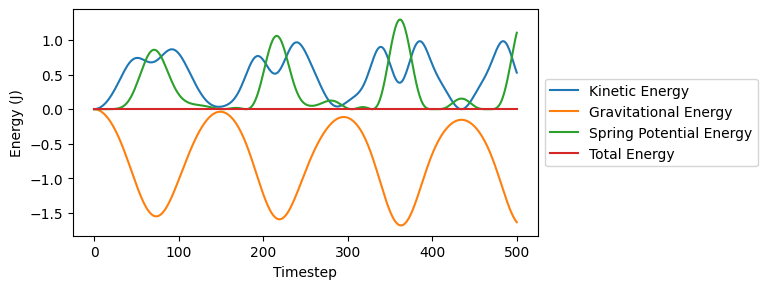

In [7]:
def kinetic_energy(s):
    vb = s[1, 2:4]
    return 0.5 * m * np.dot(vb, vb)


def gravitational_energy(s):
    y = s[1, 1]
    return m * g * y


def spring_potential_energy(s):
    pa = s[0, :2]
    pb = s[1, :2]
    d = pa - pb
    l = np.linalg.norm(d)
    x = (l - l_rest) * d / l
    return 0.5 * k * np.dot(x, x)


def plot_energies(history):
    K = np.array([kinetic_energy(s) for s in history])
    G = np.array([gravitational_energy(s) for s in history])
    SPE = np.array([spring_potential_energy(s) for s in history])

    plt.figure(figsize=(6, 3), dpi=100)
    plt.plot(K)
    plt.plot(G)
    plt.plot(SPE)
    plt.plot(K + G + SPE)
    plt.legend(['Kinetic Energy', 
                'Gravitational Energy', 
                'Spring Potential Energy', 
                'Total Energy'],
               loc='center left', 
               bbox_to_anchor=(1, 0.5))
    plt.xlabel('Timestep')
    plt.ylabel('Energy (J)')
    
plot_energies(history)